<a href="https://colab.research.google.com/github/shstudy/data/blob/main/IB_classfic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 고지혈증 환자 판단 분류 모델 
#### -건강 검진 데이터 내 콜레스테롤 관련 데이터가 누락된 사례를 중심으로-
--- 
<br/>
**📑 선정 이유**

- 국민 건강 보험 공단의 건강검진정보에는 '총 콜레스테롤, 트리글리세라이드, HDL 콜레스테롤, LDL 콜레스테롤'가 입력되지 않은 사례가 많음.
<br/>  
<br/>

**😥 환경과 목표**

*"고지혈증 검사 여부 전화를 돌려야 하는데, 누락된 데이터가 너무 많아! 다시 설문조사하기엔 시간이 걸리고..."*
- 트리글리세라이드와 총콜레스테롤의 수치가 높을 경우 고지혈증을 일으킬 수 있으나, 이 데이터가 누락되어있다. 이 변수들을 제외한 **다른 변수를 통해 고지혈증이 발병할 확률이 높은 사람들을 찾아보자.**
<br/>  
> **✅고지혈증 조건**:총콜레스테롤>=240 AND 트리글리세라이드(중성지방)>=200

<br/>

**🎯독립변수와 종속변수**
- 독립변수: 건강검진 데이터 내 총 콜레스테롤, 트리글리세라이드, HDL 콜레스테롤, LDL 콜레스테롤을 제외한 변수
- 종속변수: 고지혈증 여부
<br/>  

# [준비] 데이터 임포트 및 전처리

### 패키지 임포트 및 설치

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

In [153]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [154]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [155]:
!pip install mglearn 
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
import mglearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz
import graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score, roc_curve


## 전처리 및 데이터 분포 확인

- 엑셀로 1차 전처리 진행: 결측치 있는 데이터 삭제.


In [224]:
rawdf = pd.read_csv('https://raw.githubusercontent.com/shstudy/data/main/data_2.csv', encoding = 'CP949') #파일 불러오기

In [225]:
## 컬럼 수정, 파생변수 추가 ##
rawdf.rename(columns = {'연령대코드(5세단위)':'연령', '시도코드':'시도', '성별코드':'성별'},inplace=True) #컬럼 이름 바꾸기

sex = {'성별' : {'M':'0','F':'1'}}
rawdf.replace(sex, inplace=True)

hyperlipi = {'고지혈증여부' : {'N':'0','Y':'1'}}
rawdf.replace(hyperlipi, inplace=True)

#질병 컬럼 생성
rawdf["당뇨병여부"] = rawdf['식전혈당(공복혈당)'] >= 126
rawdf["BMI"] = rawdf['체중']/(rawdf['신장']/100*rawdf['신장']/100)
rawdf["비만여부"] = rawdf["BMI"] >= 30
rawdf["고혈압여부"] = np.where(rawdf['수축기혈압'] >= 140, 1, 0) | np.where(rawdf['이완기혈압'] >=90, 1,0)

#컬럼 자료형 float형으로 변환
rawdf = rawdf.astype('float')

#컬럼 순서 변환
rawdf=rawdf[['고지혈증여부', '비만여부', "당뇨병여부", "고혈압여부", '흡연여부', '음주여부',
       '시도', '성별', '연령', '신장', '체중', 'BMI', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)',
       '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤', 
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']]

고지혈증이 비만, 당뇨병, 고혈압 등 다른 질병과도 연관이 있는지 확인하기 위해 파생변수를 추가로 생성함.

In [226]:
df = rawdf.copy()
df.drop(labels=['시도', '체중', '신장', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤'],axis=1, inplace=True)

콜레스테롤 관련 변수와 시도, 시력, 청력 변수 삭제함. (누락된 데이터로 고지형증 여부를 판별하기 위해)

---
📊 데이터 분포 확인

In [227]:
sv = '고지혈증여부'

0.0    2957
1.0    1087
Name: 고지혈증여부, dtype: int64


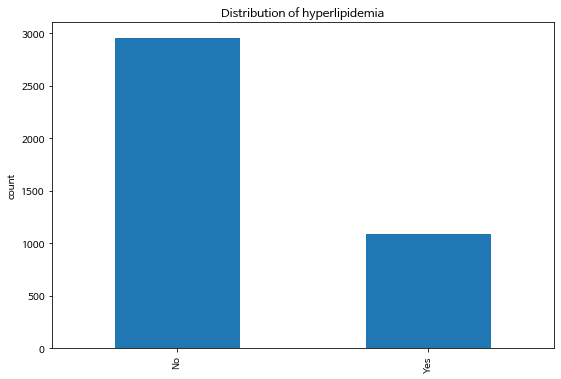

In [228]:
print(df[sv].value_counts())

df[sv].value_counts().plot.bar()
plt.ylabel('count')
plt.title('Distribution of hyperlipidemia')
plt.xticks([0, 1], labels=['No', 'Yes'])
plt.show()

⭕고지혈증 해당 데이터: 2957

❌고지혈증 해당하지 않음 데이터:1087

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


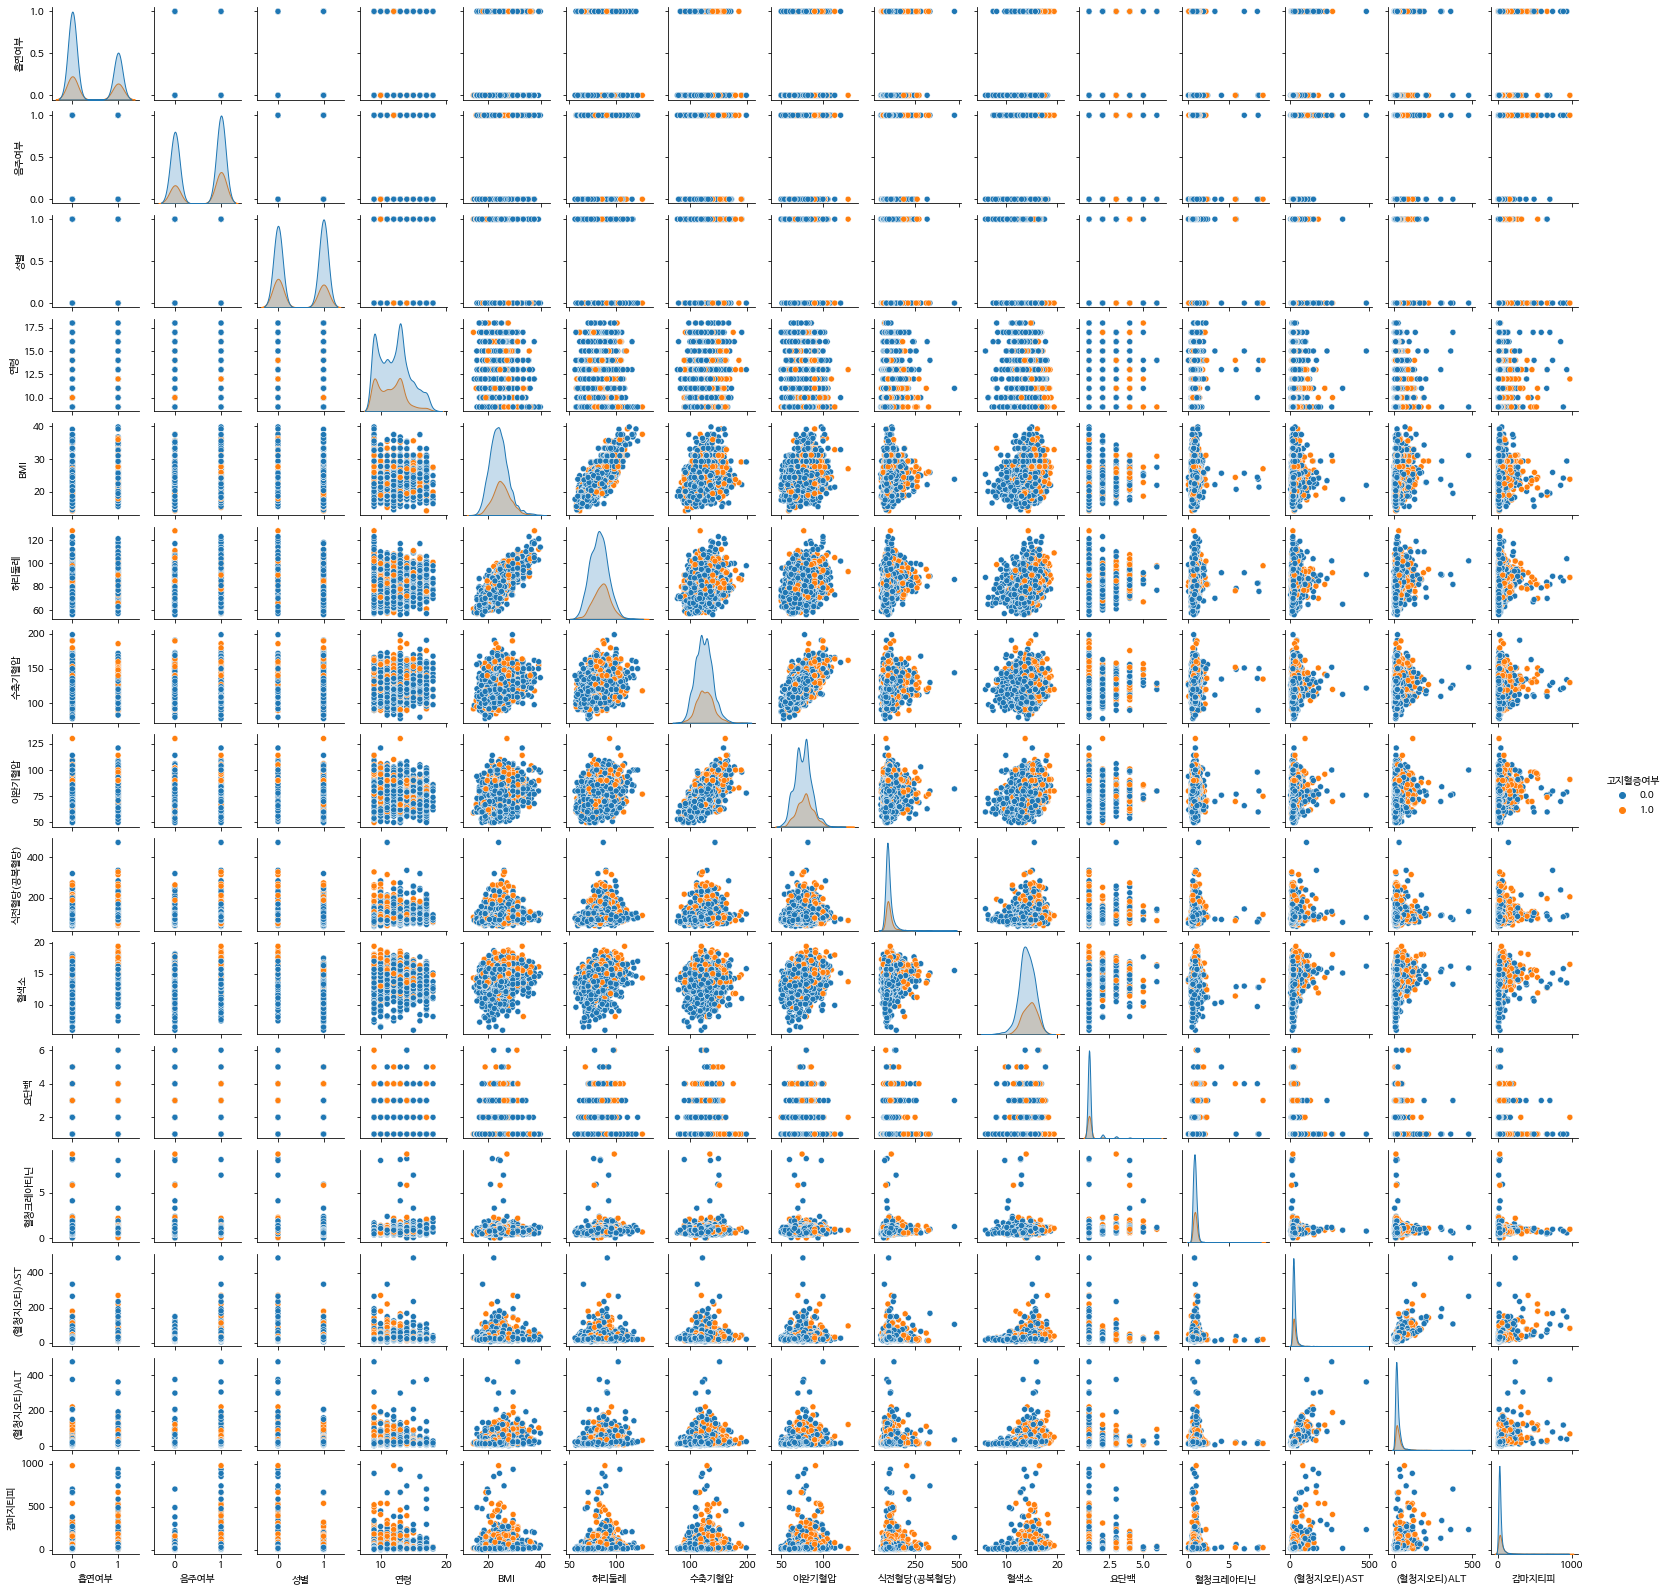

In [229]:
plotdf = df.copy()
plotdf.drop(labels=['비만여부', "당뇨병여부", "고혈압여부"],axis=1, inplace=True)

sns.pairplot(plotdf, hue='고지혈증여부', size=1.5)

# [1단계] 분류 모델 구축

## 1-1. 의사결정나무

**데이터셋을 학습(train)과 테스트(test) 세트로 분할**

< 파라미터 설정 >
- 학습용 데이터: 75%, 시험용 데이터: 25%
- tratify 값을 y으로 지정: 각각의 class 비율(ratio)을 train / validation에 유지.



In [230]:
X = df.iloc[:, 1:]  # 독립변수
y = df[sv]          # target 변수: 고지혈증 여부

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    stratify=y, random_state=17)

In [231]:
tree = DecisionTreeClassifier(random_state=16) #의사결정나무 만들기
tree.fit(X_train, y_train)

print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))

학습용 데이터 정확도: 1.000
시험용 데이터 정확도: 0.646


학습용 데이터의 정확도는 1.00으로 나온 반면, 시험용 데이터의 정확도가 0.646으로 낮게 나와 과적합의 문제가 발생함.

- ✒ 나무의 깊이를 3~9로 제한해, 시험용 데이터에 대한 성능이 향상시켜보자 (과적합 줄이기)

In [232]:
depth = [3,4,5,6,7,8,9]

In [242]:
def maxdep(i):
  for j in i:
    tree = DecisionTreeClassifier(max_depth=j,random_state=17)
    tree.fit(X_train, y_train)
    print("==========나무의 깊이 = {}===========".format(j))
    print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
    print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))
    print("=====================================\n")

In [243]:
maxdep(depth)

==========나무의 깊이 = 3===========
학습용 데이터 정확도: 0.742
시험용 데이터 정확도: 0.731

==========나무의 깊이 = 4===========
학습용 데이터 정확도: 0.748
시험용 데이터 정확도: 0.737

==========나무의 깊이 = 5===========
학습용 데이터 정확도: 0.752
시험용 데이터 정확도: 0.733

==========나무의 깊이 = 6===========
학습용 데이터 정확도: 0.768
시험용 데이터 정확도: 0.731

==========나무의 깊이 = 7===========
학습용 데이터 정확도: 0.786
시험용 데이터 정확도: 0.732

==========나무의 깊이 = 8===========
학습용 데이터 정확도: 0.804
시험용 데이터 정확도: 0.713

==========나무의 깊이 = 9===========
학습용 데이터 정확도: 0.828
시험용 데이터 정확도: 0.702



📍 나무의 깊이가 4일 때 시험용 데이터 정확도가 0.737로 가장 높으므로, 4로 설정

In [245]:
tree = DecisionTreeClassifier(max_depth=4,random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=17)

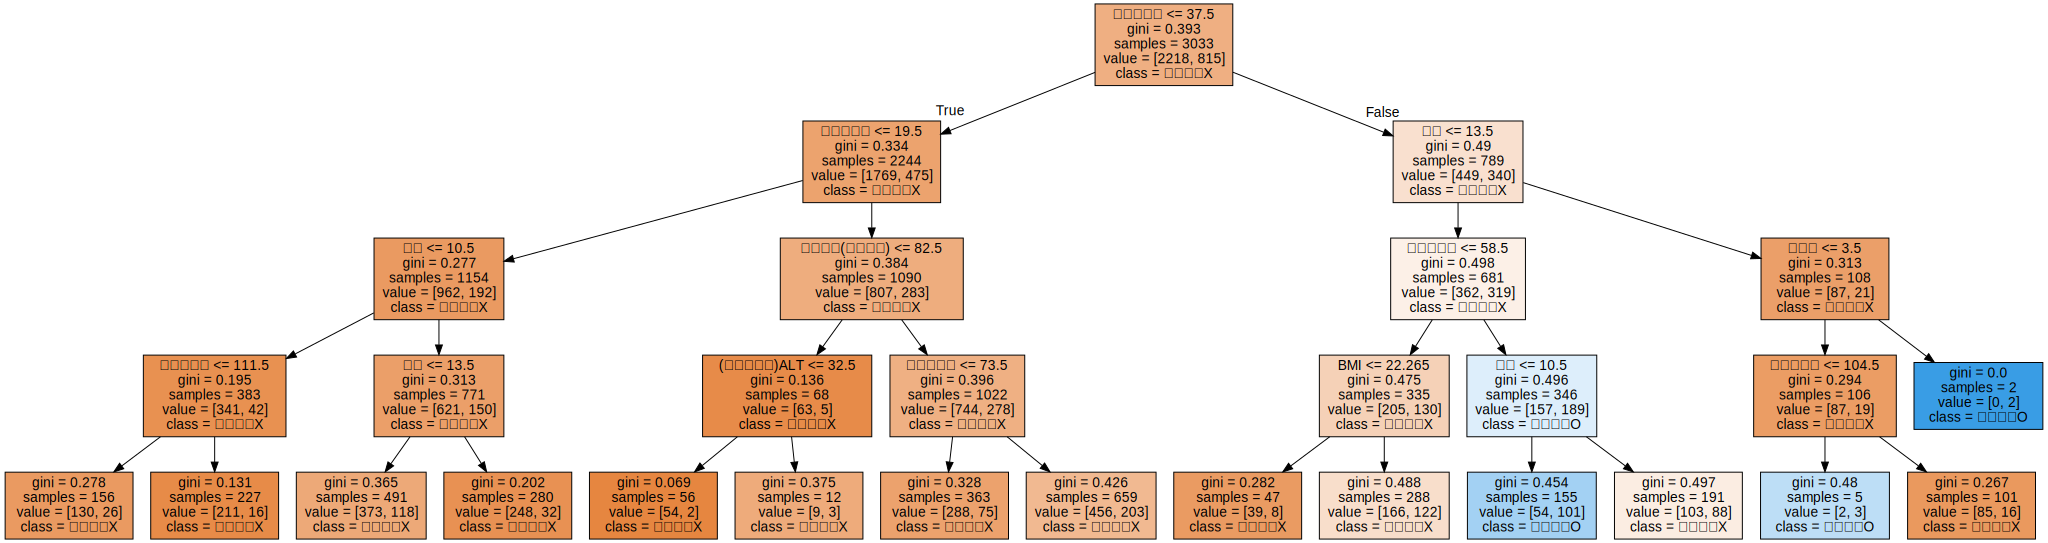

In [246]:
export_graphviz(tree, out_file="tree.dot", class_names=["고지혈증X", "고지혈증O"], 
                feature_names=df.columns[1:], impurity=True, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

감마지티피 <= 37.5에서 False로 분할된 노드에서 지니계수가 전체적으로 높게 나왔기 때문에 나무의 높이를 5로 높여서 실행함. 

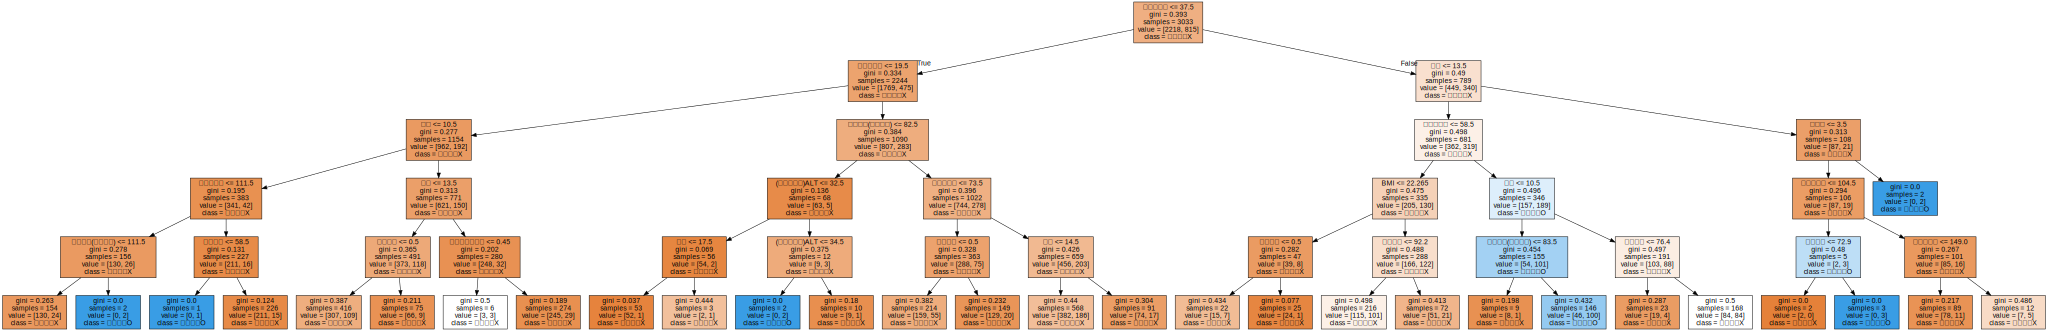

In [247]:
tree = DecisionTreeClassifier(max_depth=5,random_state=17)
tree.fit(X_train, y_train)

export_graphviz(tree, out_file="tree.dot", class_names=["고지혈증X", "고지혈증O"], 
                feature_names=df.columns[1:], impurity=True, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

<br/>
<br/>

🗂️ 의사결정나무: 변수의 중요도

In [250]:
result = tree.feature_importances_ #나무의 깊이가 5일 때 기준

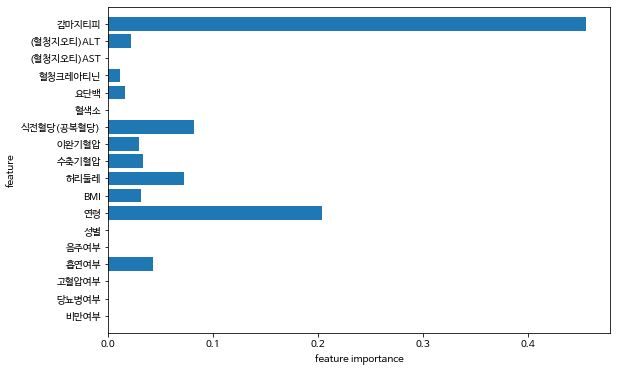

In [251]:
def plot_feature_importances_df(model):
    plt.rcParams["figure.figsize"] = (9,6)
    plt.rc('font', family='NanumBarunGothic') 
    n_features = len(df.columns[1:])
    plt.barh(np.arange(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), df.columns[1:])  
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)

plot_feature_importances_df(tree)

In [252]:
res = pd.DataFrame(result)
res["name"] = df.columns[1:]
#res.sort_values(0)

display(res.sort_values(by=0, ascending = False))  # perimeter_worst의 비중이 가장 큼, 루트 노드에서 이 값부터 사용 

,0,name
17,0.455459,감마지티피
6,0.203568,연령
11,0.082167,식전혈당(공복혈당)
8,0.072128,허리둘레
3,0.042998,흡연여부
9,0.032971,수축기혈압
7,0.031770,BMI
10,0.029488,이완기혈압
16,0.022088,(혈청지오티)ALT
13,0.016192,요단백


고지혈증여부 분류에 있어 중요한 변수
- 매우 중요: 감마지티피, 연령 변수가 중요함.
- 중요: 미미한 수치지만, 식전혈당(공복혈당), 허리둘레, 흡연여부, 수축기혈압, BMI, 이완기혈압, (혈청지오티)ALT, 요단백, 혈청크레아티닌 변수가 중요도가 있었음.
- 중요하지 않음: 음주여부, 당뇨병여부, 고혈압여부, 혈색소, (혈청지오티)AST, 비만여부

<br/>
✅ 합병증 관계: 당뇨병, 고혈압, 비만 등 다른 질병과의 연관이 있을 것이라 예측했으나 실제 분류에서는 오히려 중요하지 않았음.
<br/>
✅ 감마지티피가 가장 중요도가 높은데, 고지혈증의 결정 요소로 혈액의로부터의 지방 제거량이 간으로의 흡수 및 대사 역량과 연관이 있기 때문에 높게 나타난 것으로 예상됨.

## 1-2. 앙상블모델 - 랜덤 포레스트

모든 변수를 사용한 랜덤포레스트

In [314]:
forest = RandomForestClassifier(n_estimators=100, random_state=17) # 모든 변수를 이용하여 200개의 나무 생성
forest.fit(X_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

학습용 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.742


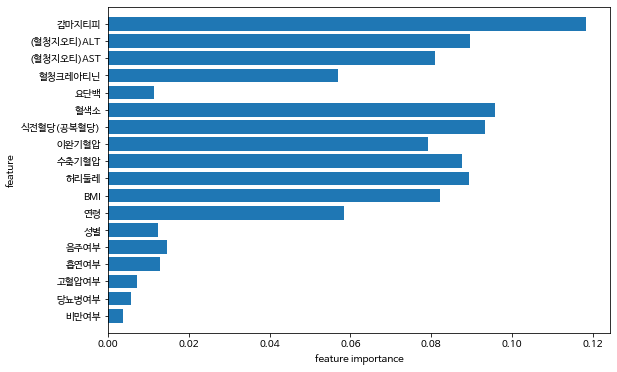

In [310]:
plot_feature_importances_df(forest)

단일의사결정나무에 비해 랜덤 포레스트의 시험용 데이터 정확도가 높으나 둘 다 과적합의 문제가 있다.
단일 의사결정나무의 경우보다 많은 변수들이 사용되었다.

- 중요변수: 감마지티피, ALT, AST, 혈색소, 식전혈당, 허리둘레, 이완기/수축기혈압, BMI, 연령, 혈청크레아티닌



특정 변수만 사용한 랜덤 포레스트

In [301]:
list_a = X.columns

In [306]:
def ranfoG5(a): # 감마지티피와 특정 변수만 이용하여 5개의 나무를 만드는 함수
  for b in a:
    forest = RandomForestClassifier(n_estimators=5, random_state=17) 
    forest.fit(X_train[['감마지티피', b]], y_train) 
    print("=======독립변수: 감마지티피, {}=======".format(b))
    print("학습용 데이터 세트 정확도: {:.3f}".format(forest.score(X_train[['감마지티피', b]], y_train)))
    print("시험용 데이터 세트 정확도: {:.3f}".format(forest.score(X_test[['감마지티피', b]], y_test)))
    print("\n")

In [307]:
ranfoG5(list_a)

=======독립변수: 감마지티피, 비만여부=======
학습용 데이터 세트 정확도: 0.768
시험용 데이터 세트 정확도: 0.728


=======독립변수: 감마지티피, 당뇨병여부=======
학습용 데이터 세트 정확도: 0.766
시험용 데이터 세트 정확도: 0.726


=======독립변수: 감마지티피, 고혈압여부=======
학습용 데이터 세트 정확도: 0.773
시험용 데이터 세트 정확도: 0.709


=======독립변수: 감마지티피, 흡연여부=======
학습용 데이터 세트 정확도: 0.769
시험용 데이터 세트 정확도: 0.722


=======독립변수: 감마지티피, 음주여부=======
학습용 데이터 세트 정확도: 0.768
시험용 데이터 세트 정확도: 0.711


=======독립변수: 감마지티피, 성별=======
학습용 데이터 세트 정확도: 0.768
시험용 데이터 세트 정확도: 0.711


=======독립변수: 감마지티피, 연령=======
학습용 데이터 세트 정확도: 0.795
시험용 데이터 세트 정확도: 0.701


=======독립변수: 감마지티피, BMI=======
학습용 데이터 세트 정확도: 0.853
시험용 데이터 세트 정확도: 0.659


=======독립변수: 감마지티피, 허리둘레=======
학습용 데이터 세트 정확도: 0.868
시험용 데이터 세트 정확도: 0.676


=======독립변수: 감마지티피, 수축기혈압=======
학습용 데이터 세트 정확도: 0.856
시험용 데이터 세트 정확도: 0.670


=======독립변수: 감마지티피, 이완기혈압=======
학습용 데이터 세트 정확도: 0.847
시험용 데이터 세트 정확도: 0.679


=======독립변수: 감마지티피, 식전혈당(공복혈당)=======
학습용 데이터 세트 정확도: 0.868
시험용 데이터 세트 정확도: 0.652


=======독립변수: 감마지티피, 혈색소=======
학습용 데이터 세트 정확도: 0.861
시험용 데이

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


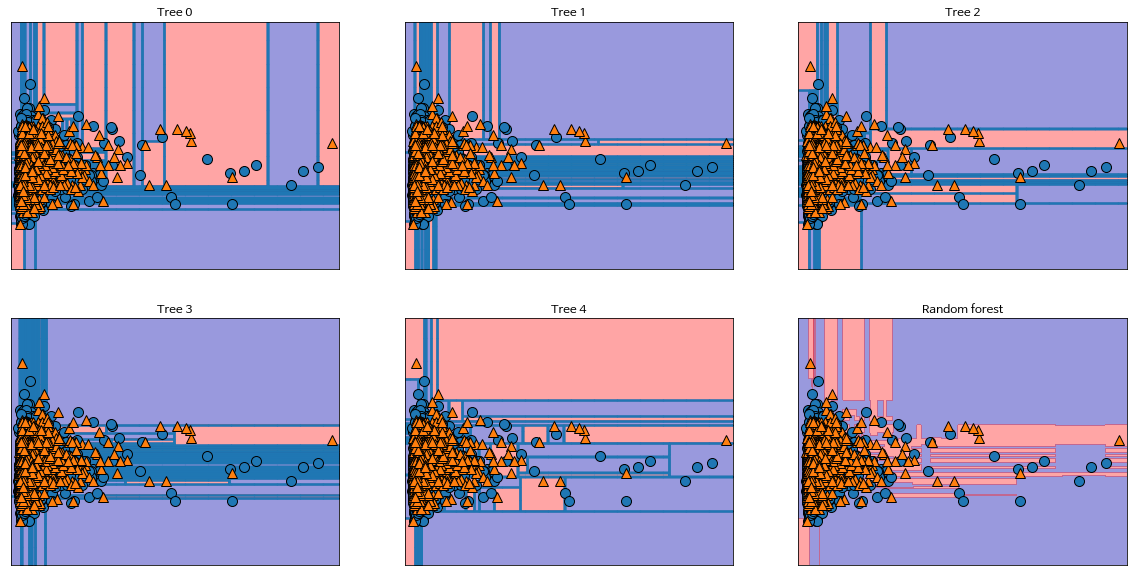

In [321]:
forest = RandomForestClassifier(n_estimators=5, random_state=17)
forest.fit(X_train[['감마지티피', '이완기혈압']], y_train) 

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X[['감마지티피', '이완기혈압']].values, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X[['감마지티피', '이완기혈압']].values, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random forest")
mglearn.discrete_scatter(X.iloc[:, -1], X.iloc[:, -8], y)
plt.show()

두 가지 변수를 쓸 때 정확도가 낮아지는 것을 보아, 여러 변수를 사용하여 랜덤포레스트를 써야 함.

In [ ]:
forest = RandomForestClassifier(n_estimators=100, random_state=17)
forest.fit(X_train, y_train)

----

# [비교] 랜덤 포레스트 vs 단일 의사결정나무 


In [324]:
# 교차 검증을 10번 수행하여 10번의 교차 검증 평균 정확도를 비교 (10-fold cross validation)
# default cv=5

dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')

print("=======Accuracy===========")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 

print("=======Accuracy mean=======")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 

=======Accuracy===========
Decision tree:  [0.58881579 0.61513158 0.63815789 0.6369637  0.64686469 0.61386139
 0.66006601 0.6039604  0.62046205 0.62376238]
Random forest:  [0.73026316 0.76644737 0.69736842 0.72607261 0.75247525 0.7359736
 0.76567657 0.7359736  0.74257426 0.7359736 ]
=======Accuracy mean=======
Decision tree :0.625
Random forest :0.739


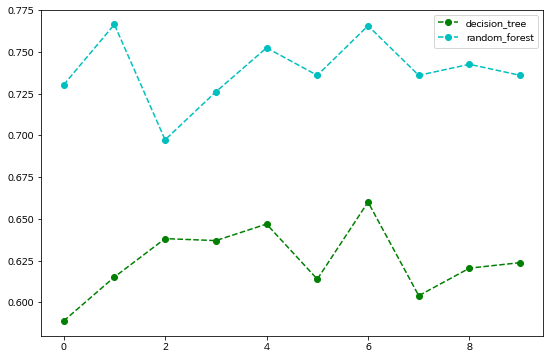

In [341]:
cv_list = [ ['decision_tree',dt_scores],
            ['random_forest',rf_scores],]
linedf = pd.DataFrame.from_dict(dict(cv_list))
linedf.plot(kind='line', color=['g','c'],marker='o',linestyle='--')

라인 차트를 그려봄으로써 랜덤포레스트가 의사결정트리보다 매번 정확도가 확연히 높음을 알 수 있고 10% 정확도를 높일 수 있다는 것을 확인했다.

##1-3. 앙상블모델 - 그래디언트 부스팅

In [376]:
gbrt = GradientBoostingClassifier(random_state=17, n_estimators=125, 
                                  learning_rate = 0.01, max_depth=4)
#학습률을 0.1보다 감소시키고, n_estimators값을 25 키워 트리를 추가했다.
gbrt.fit(X_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

학습용 데이터 세트 정확도: 0.759
시험용 데이터 세트 정확도: 0.740


✅그리드 서치로 최적의 파라미터 조합 찾기

In [403]:
parameters = {'max_depth':[3,4,5], 'learning_rate':[0.1,0.08, 0.06, 0.04, 0.01]}

In [404]:
init_gbrt = GradientBoostingClassifier(random_state=0)
grid_gbrt = GridSearchCV(init_gbrt, param_grid=parameters, cv=3, refit=True)
print(grid_gbrt)
grid_gbrt.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_gbrt.cv_results_)# GridSearchCV 결과 
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']]

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.1, 0.08, 0.06, 0.04, 0.01],
                         'max_depth': [3, 4, 5]})


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': 0.1, 'max_depth': 3}",0.737554,4,0.730959,0.735905,0.745796
1,"{'learning_rate': 0.1, 'max_depth': 4}",0.727992,14,0.721068,0.730959,0.731949
2,"{'learning_rate': 0.1, 'max_depth': 5}",0.725354,15,0.727003,0.732938,0.716123
3,"{'learning_rate': 0.08, 'max_depth': 3}",0.738213,3,0.726014,0.742829,0.745796
4,"{'learning_rate': 0.08, 'max_depth': 4}",0.734586,7,0.733927,0.740851,0.728981
5,"{'learning_rate': 0.08, 'max_depth': 5}",0.728981,13,0.732938,0.729970,0.724036
6,"{'learning_rate': 0.06, 'max_depth': 3}",0.739202,1,0.727992,0.740851,0.748764
7,"{'learning_rate': 0.06, 'max_depth': 4}",0.734916,6,0.730959,0.737883,0.735905
8,"{'learning_rate': 0.06, 'max_depth': 5}",0.736235,5,0.727992,0.737883,0.742829
9,"{'learning_rate': 0.04, 'max_depth': 3}",0.738543,2,0.733927,0.737883,0.743818


In [405]:
print('GridSearchCV 최적 파라미터:', grid_gbrt.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_gbrt.best_score_))
print("시험용 데이터 세트 정확도: {:.3f}".format(grid_gbrt.score(X_test, y_test))) # 최적 파라미터로 학습이 된 모델을 이용하여 시험용 데이터 세트 분류

GridSearchCV 최적 파라미터: {'learning_rate': 0.06, 'max_depth': 3}
GridSearchCV 최고 정확도: 0.7392
시험용 데이터 세트 정확도: 0.738


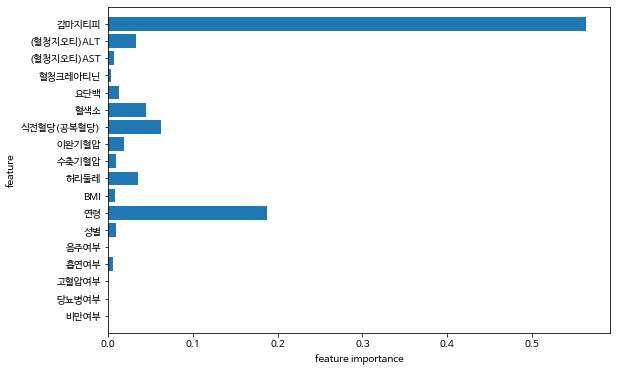

In [380]:
plot_feature_importances_df(gbrt)

- 의사결정나무와 비슷한 형태로, '감마지티피'와 '연령'이 가장 중요한 변수로 나타났다. (추가로, 그래디언트 부스팅과 같이 다양한 변수를 사용한 것으로 보인다)

#[2단계] 모델 평가

### 2-1. 교차 검증

In [394]:
# 교차 검증을 10번 수행하여 10번의 교차 검증 평균 정확도를 비교 (10-fold cross validation)
# default cv=5

dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=10, scoring='accuracy')

print("===Accuracy==================")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 
print("Gradient boosting: ", gbrt_scores, '\n') 

print("===Accuracy mean=============")
print("Decision tree :{:.3f}".format(dt_scores.mean()))
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean(),'\n')) 

kf = StratifiedKFold(n_splits=10)
print("")

dt_scores = cross_val_score(tree, X_train, y_train, cv=kf, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=kf, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=kf, scoring='accuracy')

print("===Accuracy mean============= *StratifiedKFold 이용")
print(kf)
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 

===Accuracy==================
Decision tree:  [0.58881579 0.61513158 0.63815789 0.6369637  0.64686469 0.61386139
 0.66006601 0.6039604  0.62046205 0.62376238]
Random forest:  [0.73026316 0.76644737 0.69736842 0.72607261 0.75247525 0.7359736
 0.76567657 0.7359736  0.74257426 0.7359736 ]
Gradient boosting:  [0.73026316 0.73026316 0.71710526 0.73267327 0.72607261 0.72937294
 0.72937294 0.73267327 0.72937294 0.72937294] 

===Accuracy mean=============
Decision tree :0.625
Random forest :0.739
Gradient boosting :0.729

===Accuracy mean============= *StratifiedKFold 이용
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
Decision tree :0.625
Random forest :0.739
Gradient boosting :0.729


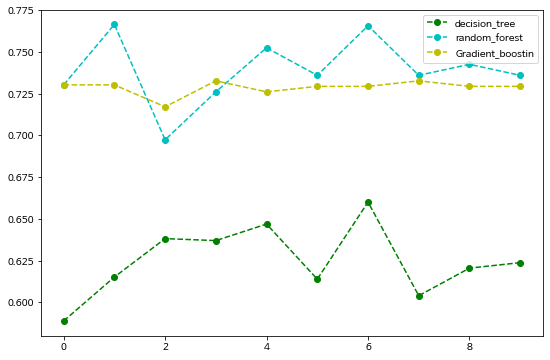

In [401]:
cv_list2 = [ ['decision_tree',dt_scores],
            ['random_forest',rf_scores],
           ['Gradient_boostin',gbrt_scores],
           ]

linedf = pd.DataFrame.from_dict(dict(cv_list2))
linedf.plot(kind='line', color=['g','c','y'],marker='o',linestyle='--')

🎯최적의 모델: 랜덤 포레스트 기법 사용 모델

- 각 기법을 적용한 모델의 정확도를 시각화했을 때, 랜덤포레스트와 그래디언트부스팅 기법을 사용한 모델이 의사결정나무에 비해 정확도가 명확하게 높음을 볼 수 있음. 
- 특히, 랜덤 포레스트는 0.739라는 수치로, 그래디언트부스팅보다 조금 더 높은 정확도 평균을 보여주고 있음

-----
📍 정오 분류표

In [408]:
print(y_test.value_counts()) # y_test 의 고지혈증 해당(1), 고지혈증X(0) 분포

0.0    739
1.0    272
Name: 고지혈증여부, dtype: int64


In [422]:
tree = DecisionTreeClassifier(max_depth=5,random_state=17)
tree.fit(X_train, y_train)

dt_pred = tree.predict(X_test)
rf_pred = forest.predict(X_test)
grid_gbrt_pred = grid_gbrt.predict(X_test)

# 예측 결과인 pred와 실제 결과인 y_test의 Confusion Matrix 출력
print('Decision tree 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, dt_pred)))
print(confusion_matrix(y_test, dt_pred),"\n")
print('Random forest 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, rf_pred)))
print(confusion_matrix(y_test, rf_pred),"\n")
print('Gradient boosting 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, grid_gbrt_pred)))
print(confusion_matrix(y_test, grid_gbrt_pred),"\n")

Decision tree 시험용 데이터 세트 정확도:0.733
[[713  26]
 [244  28]] 

Random forest 시험용 데이터 세트 정확도:0.742
[[706  33]
 [228  44]] 

Gradient boosting 시험용 데이터 세트 정확도:0.738
[[702  37]
 [228  44]] 



*정확도(accuracy), 민감도(sensitivity), 특이도(specificity), 정밀도(precistion), 재현률(recall), F1-measure

In [426]:
print('정밀도:{:.3f}'.format(precision_score (y_test, grid_gbrt_pred, average='binary', pos_label=1)))  # pos_label = 1 기본값
print('TP (49) / TP+FP (52) = {:.3f}'.format(49/52),'\n')
print('재현율:{:.3f}'.format(recall_score(y_test, grid_gbrt_pred, average='binary', pos_label=1)))
print('TP (49) / TP+FN (51) = {:.3f}'.format(49/51),'\n')
print('f1-measure:{:.3f}'.format(f1_score(y_test, grid_gbrt_pred, average='binary', pos_label=1)))
print('2*(정밀도*재현율)/(정밀도+재현율) = {:.3f}'.format(2*0.942*0.961/(0.942+0.961)))

정밀도:0.543
TP (49) / TP+FP (52) = 0.942 

재현율:0.162
TP (49) / TP+FN (51) = 0.961 

f1-measure:0.249
2*(정밀도*재현율)/(정밀도+재현율) = 0.951


의료 관련 판단 모델의 경우,

In [432]:
from sklearn.metrics import classification_report

# 각 클래스가 Positive일 때의 정밀도, 재현율, f1 값을 보여줌
print("고지혈증 해당 여부","\n Decision Tree:")
print(classification_report(y_test, dt_pred, target_names=["X", "O"]))
print("Random Forest:")
print(classification_report(y_test, rf_pred, target_names=["X", "O"]))
print("Gradient Boosting:")
print(classification_report(y_test, grid_gbrt_pred, target_names=["X", "O"]))

고지혈증 해당 여부 
 Decision Tree:
              precision    recall  f1-score   support

           X       0.75      0.96      0.84       739
           O       0.52      0.10      0.17       272

    accuracy                           0.73      1011
   macro avg       0.63      0.53      0.51      1011
weighted avg       0.68      0.73      0.66      1011

Random Forest:
              precision    recall  f1-score   support

           X       0.76      0.96      0.84       739
           O       0.57      0.16      0.25       272

    accuracy                           0.74      1011
   macro avg       0.66      0.56      0.55      1011
weighted avg       0.71      0.74      0.68      1011

Gradient Boosting:
              precision    recall  f1-score   support

           X       0.75      0.95      0.84       739
           O       0.54      0.16      0.25       272

    accuracy                           0.74      1011
   macro avg       0.65      0.56      0.55      1011
weighted avg

📍 ROC (Receiver Operator Characteristic) 곡선과 AUC (Aread Under the Curve)

[[0.84415584 0.15584416]
 [0.67253521 0.32746479]
 [0.67253521 0.32746479]
 ...
 [0.89416058 0.10583942]
 [0.31506849 0.68493151]
 [0.67253521 0.32746479]]


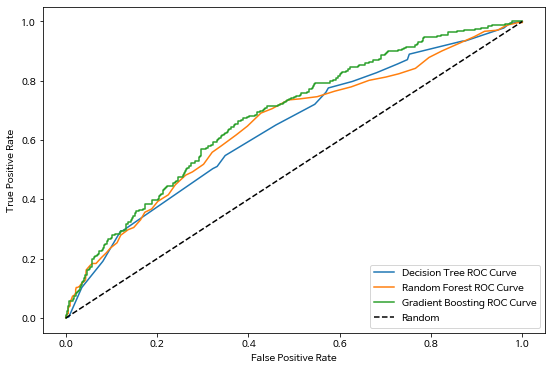

In [434]:
print(tree.predict_proba(X_test))

fpr_dt, tpr_dt, cutoff_dt = roc_curve(y_test, tree.predict_proba(X_test)[:, 1], pos_label=1)
fpr_rf, tpr_rf, cutoff_rf = roc_curve(y_test, forest.predict_proba(X_test)[:, 1], pos_label=1)
fpr_gbrt, tpr_gbrt, cutoff_gbrt = roc_curve(y_test, grid_gbrt.predict_proba(X_test)[:, 1], pos_label=1)

plt.plot(fpr_dt, tpr_dt, label="Decision Tree ROC Curve")
plt.plot(fpr_rf, tpr_rf, label="Random Forest ROC Curve")
plt.plot(fpr_gbrt, tpr_gbrt, label="Gradient Boosting ROC Curve")
plt.plot([0,1], [0, 1], "k--", label ="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc=4)
plt.show() 

In [435]:
auc_dt = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
auc_gbrt = roc_auc_score(y_test, grid_gbrt.predict_proba(X_test)[:, 1])
print("Decision Tree의 AUC: {:.3f}".format(auc_dt))
print("Random Forest의 AUC: {:.3f}".format(auc_rf))
print("Gradient Boosting의 AUC: {:.3f}".format(auc_gbrt)) ## AUC 면적이 가장 큰 모델

Decision Tree의 AUC: 0.637
Random Forest의 AUC: 0.649
Gradient Boosting의 AUC: 0.681
